# 稠密连接网络（DenseNet）

ResNet极大地改变了如何参数化深层网络中函数的观点。
*稠密连接网络*（DenseNet） :cite:`Huang.Liu.Van-Der-Maaten.ea.2017`在某种程度上是ResNet的逻辑扩展。让我们先从数学上了解一下。

## 从ResNet到DenseNet

回想一下任意函数的泰勒展开式（Taylor expansion），它把这个函数分解成越来越高阶的项。在$x$接近0时，

$$f(x) = f(0) + f'(0) x + \frac{f''(0)}{2!}  x^2 + \frac{f'''(0)}{3!}  x^3 + \ldots.$$

同样，ResNet将函数展开为

$$f(\mathbf{x}) = \mathbf{x} + g(\mathbf{x}).$$

也就是说，ResNet将$f$分解为两部分：一个简单的线性项和一个更复杂的非线性项。
那么再向前拓展一步，如果我们想将$f$拓展成超过两部分的信息呢？
一种方案便是DenseNet。

![ResNet（左）与 DenseNet（右）在跨层连接上的主要区别：使用相加和使用连结。](../img/densenet-block.svg)
:label:`fig_densenet_block`

如 :numref:`fig_densenet_block`所示，ResNet和DenseNet的关键区别在于，DenseNet输出是*连接*（用图中的$[,]$表示）而不是如ResNet的简单相加。
因此，在应用越来越复杂的函数序列后，我们执行从$\mathbf{x}$到其展开式的映射：

$$\mathbf{x} \to \left[
\mathbf{x},
f_1(\mathbf{x}),
f_2([\mathbf{x}, f_1(\mathbf{x})]), f_3([\mathbf{x}, f_1(\mathbf{x}), f_2([\mathbf{x}, f_1(\mathbf{x})])]), \ldots\right].$$

最后，将这些展开式结合到多层感知机中，再次减少特征的数量。
实现起来非常简单：我们不需要添加术语，而是将它们连接起来。
DenseNet这个名字由变量之间的“稠密连接”而得来，最后一层与之前的所有层紧密相连。
稠密连接如 :numref:`fig_densenet`所示。

![稠密连接。](../img/densenet.svg)
:label:`fig_densenet`

稠密网络主要由2部分构成：*稠密块*（dense block）和*过渡层*（transition layer）。
前者定义如何连接输入和输出，而后者则控制通道数量，使其不会太复杂。

## (**稠密块体**)

DenseNet使用了ResNet改良版的“批量规范化、激活和卷积”架构（参见 :numref:`sec_resnet`中的练习）。
我们首先实现一下这个架构。


In [1]:
import torch
from torch import nn
from d2l import torch as d2l


def conv_block(input_channels, num_channels):
    return nn.Sequential(
        nn.BatchNorm2d(input_channels), nn.ReLU(),
        nn.Conv2d(input_channels, num_channels, kernel_size=3, padding=1))


一个*稠密块*由多个卷积块组成，每个卷积块使用相同数量的输出信道。
然而，在前向传播中，我们将每个卷积块的输入和输出在通道维上连结。


In [2]:
class DenseBlock(nn.Module):
    def __init__(self, num_convs, input_channels, num_channels):
        super(DenseBlock, self).__init__()
        layer = []
        for i in range(num_convs):
            # 每一层都是原始的x连上前面几层的输入，输出通道都是固定的
            layer.append(conv_block(
                num_channels * i + input_channels, num_channels))
        self.net = nn.Sequential(*layer)

    def forward(self, X):
        for blk in self.net:
            Y = blk(X)
            # 连接通道维度上每个块的输入和输出
            # 实现时为了方便，直接加到X上，而不是构建一个新的tensor
            X = torch.cat((X, Y), dim=1)
        return X


在下面的例子中，我们[**定义一个**]有2个输出通道数为10的(**`DenseBlock`**)。
使用通道数为3的输入时，我们会得到通道数为$3+2\times 10=23$的输出。
卷积块的通道数控制了输出通道数相对于输入通道数的增长，因此也被称为*增长率*（growth rate）。


In [3]:
blk = DenseBlock(2, 3, 10)
X = torch.randn(4, 3, 8, 8)
Y = blk(X)
Y.shape


torch.Size([4, 23, 8, 8])

## [**过渡层**]

由于每个稠密块都会带来通道数的增加，使用过多则会过于复杂化模型。
而过渡层可以用来控制模型复杂度。
它通过$1\times 1$卷积层来减小通道数，并使用步幅为2的平均汇聚层减半高和宽，从而进一步降低模型复杂度。


In [4]:
def transition_block(input_channels, num_channels):
    return nn.Sequential(
        nn.BatchNorm2d(input_channels), nn.ReLU(),
        nn.Conv2d(input_channels, num_channels, kernel_size=1),
        nn.AvgPool2d(kernel_size=2, stride=2))


对上一个例子中稠密块的输出[**使用**]通道数为10的[**过渡层**]。
此时输出的通道数减为10，高和宽均减半。


In [5]:
blk = transition_block(23, 10)
blk(Y).shape


torch.Size([4, 10, 4, 4])

## [**DenseNet模型**]

我们来构造DenseNet模型。DenseNet首先使用同ResNet一样的单卷积层和最大汇聚层。


In [7]:
b1 = nn.Sequential(
    nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
    nn.BatchNorm2d(64), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1))


接下来，类似于ResNet使用的4个残差块，DenseNet使用的是4个稠密块。
与ResNet类似，我们可以设置每个稠密块使用多少个卷积层。
这里我们设成4，从而与 :numref:`sec_resnet`的ResNet-18保持一致。
稠密块里的卷积层通道数（即增长率）设为32，所以每个稠密块将增加128个通道。

在每个模块之间，ResNet通过步幅为2的残差块减小高和宽，DenseNet则使用过渡层来减半高和宽，并减半通道数。


In [8]:
# `num_channels`为当前的通道数
num_channels, growth_rate = 64, 32
num_convs_in_dense_blocks = [4, 4, 4, 4]
blks = []
for i, num_convs in enumerate(num_convs_in_dense_blocks):
    blks.append(DenseBlock(num_convs, num_channels, growth_rate))
    # 上一个稠密块的输出通道数
    num_channels += num_convs * growth_rate
    # 在稠密块之间添加一个转换层，使通道数量减半
    # 最后一层不需要过渡层
    if i != len(num_convs_in_dense_blocks) - 1:
        blks.append(transition_block(num_channels, num_channels // 2))
        num_channels = num_channels // 2


与ResNet类似，最后接上全局汇聚层和全连接层来输出结果。


In [9]:
net = nn.Sequential(
    b1, *blks,
    nn.BatchNorm2d(num_channels), nn.ReLU(),
    nn.AdaptiveMaxPool2d((1, 1)),
    nn.Flatten(),
    nn.Linear(num_channels, 10))


In [15]:
from torchsummary import summary

net.to(d2l.try_gpu(0))
summary(net, (1, 224, 224), batch_size=256)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [256, 64, 112, 112]           3,200
       BatchNorm2d-2        [256, 64, 112, 112]             128
              ReLU-3        [256, 64, 112, 112]               0
         MaxPool2d-4          [256, 64, 56, 56]               0
       BatchNorm2d-5          [256, 64, 56, 56]             128
              ReLU-6          [256, 64, 56, 56]               0
            Conv2d-7          [256, 32, 56, 56]          18,464
       BatchNorm2d-8          [256, 96, 56, 56]             192
              ReLU-9          [256, 96, 56, 56]               0
           Conv2d-10          [256, 32, 56, 56]          27,680
      BatchNorm2d-11         [256, 128, 56, 56]             256
             ReLU-12         [256, 128, 56, 56]               0
           Conv2d-13          [256, 32, 56, 56]          36,896
      BatchNorm2d-14         [256, 160,

## [**训练模型**]

由于这里使用了比较深的网络，本节里我们将输入高和宽从224降到96来简化计算。


loss 0.148, train acc 0.945, test acc 0.902
6649.0 examples/sec on cuda:1


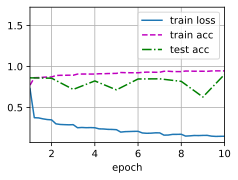

In [10]:
lr, num_epochs, batch_size = 0.1, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu(1))


## 小结

* 在跨层连接上，不同于ResNet中将输入与输出相加，稠密连接网络（DenseNet）在通道维上连结输入与输出。
* DenseNet的主要构建模块是稠密块和过渡层。
* 在构建DenseNet时，我们需要通过添加过渡层来控制网络的维数，从而再次减少信道的数量。

## 练习

1. 为什么我们在过渡层使用平均汇聚层而不是最大汇聚层？
1. DenseNet的优点之一是其模型参数比ResNet小。为什么呢？
1. DenseNet一个诟病的问题是内存或显存消耗过多。
    1. 真的是这样吗？可以把输入形状换成$224 \times 224$，来看看实际的显存消耗。
    1. 你能想出另一种方法来减少显存消耗吗？你需要如何改变框架？
1. 实现DenseNet论文 :cite:`Huang.Liu.Van-Der-Maaten.ea.2017`表1所示的不同DenseNet版本。
1. 应用DenseNet的思想设计一个基于多层感知机的模型。将其应用于 :numref:`sec_kaggle_house`中的房价预测任务。


[Discussions](https://discuss.d2l.ai/t/1880)


In [ ]:
# A1: 一个网友的解答，感觉有道理
# 我觉得从平均池化和最大池化的特性来看，平均池化的特点是保留背景信息让每一个信息对最后的输出都有帮助，最大池化的特点是提取特征只保留特征最明显的信息，当我们费劲心力吧不同层的信息叠在了一起以后用最大池化等于前面都做了无用功。

# A2: 一个网友的解答：主要从densenet有意的人为控制通道大小角度来思考，很有道理
# 教材中DenseNet于ResNet的卷积层层数及全连接层层数都是一样的，而网络的参数量也主要来自这两个部分。造成差距的主要原因在于卷积层和全连接层在通道数目上的差异。DenseNet通过过渡层不断控制通道数量，每个卷积的输入、输出通道数都没有超过256；反观ResNet，block3中5个卷积层输出通道均为256，block4中5个卷积层输出通道均为512，导致卷积层的参数量大幅增加；此外，在单层参数量最大的全连接层中，DenseNet输入通道数为248，远小于ResNet的512，因此在这一部分也获得了巨大的优势，最终使得DenseNet总体参数量比ResNet有了显著的下降

# A3: 显存占用高我理解主要是输入的数据不停的cat,产生了大量的中间变量导致占用升高，resnet是相加，没有产生巨量的中间变量。论文给出了改进措施，通过开辟share memory space实现


In [1]:
# A4
import re
from matplotlib.pyplot import isinteractive
import torch
import torchvision
from torch import nn
import torch.utils.checkpoint as cp
from typing import List, Tuple
from collections import OrderedDict
from torch.hub import load_state_dict_from_url


class _DenseLayer(nn.Module):
    def __init__(self, in_channels, growth_rate, bn_size, dropout_rate, memory_efficient: bool):
        super().__init__()
        self.memory_efficient = memory_efficient
        self.dropout_rate = dropout_rate
        # 用于bottleneck的forward计算，标号2表示加载checkpoints
        # 这里用先标识了每个层的类型
        self.norm1: nn.BatchNorm2d
        self.relu1: nn.ReLU
        self.conv1: nn.Conv2d
        self.norm2: nn.BatchNorm2d
        self.relu2: nn.ReLU
        self.conv2: nn.Conv2d
        self.drop: nn.Dropout2d
        # 添加bottleneck到网络中
        self.add_module('norm1', nn.BatchNorm2d(in_channels))
        self.add_module('relu1', nn.ReLU(inplace=True))
        self.add_module('conv1', nn.Conv2d(
            in_channels, bn_size * growth_rate, kernel_size=1, stride=1, bias=False))
        self.add_module('norm2', nn.BatchNorm2d(bn_size * growth_rate))
        self.add_module('relu2', nn.ReLU(inplace=True))
        self.add_module('conv2', nn.Conv2d(bn_size * growth_rate,
                        growth_rate, kernel_size=3, stride=1, padding=1, bias=False))
        if self.dropout_rate > 0:
            self.add_module('drop', nn.Dropout2d(self.dropout_rate))

    def bottleneck(self, input: List[torch.Tensor]):
        concated_features = torch.cat(input, dim=1)
        bottle_neck_outputs = self.conv1(
            self.relu1(self.norm1(concated_features)))
        return bottle_neck_outputs

    @torch.jit.unused
    def call_checkpoints_bottleneck(self, input: List[torch.Tensor]):
        def closure(*inputs):
            return self.bottleneck(inputs)
        return cp.checkpoint(closure, *input)

    def forward(self, input: torch.Tensor):
        # 若输入不是list，则转换为list
        if isinstance(input, torch.Tensor):
            prev_features = [input]
        else:
            prev_features = input
        if self.memory_efficient:
            bottleneck_output = self.call_checkpoints_bottleneck(prev_features)
        else:
            bottleneck_output = self.bottleneck(prev_features)
        new_features = self.conv2(self.relu2(self.norm2(bottleneck_output)))
        if self.dropout_rate > 0:
            new_features = self.drop(new_features)
        return new_features


class _DenseBlock(nn.ModuleDict):
    '''
    stacked dense layers to form a dense block
    '''

    def __init__(self, num_layers, in_channels, growth_rate, bn_size, dropout_rate, memory_efficient) -> None:
        super().__init__()
        for i in range(num_layers):
            layer = _DenseLayer(in_channels + growth_rate * i,
                                growth_rate, bn_size, dropout_rate, memory_efficient)
            # 层的标识下标是从1开始，计算size时使用0开始会更方便
            self.add_module(f'denselayer {i+1}', layer)

    def forward(self, x: torch.Tensor):
        # 先将上个denseblock放入一个列表，然后逐渐添加各denselayer的输出
        # features 会在每个denselayer中的bottlelayer进行concat，然后再进行计算
        # 这样通过denselayer中的checkpoints模块函数进行管理，可以实现memory efficient
        features = [x]
        # self.items()以OrderDict的方式访问self._modules中的layers
        for name, layer in self.items():
            new_features = layer(features)
            features.append(new_features)
        return torch.cat(features, 1)


class _Transition(nn.Module):
    '''
    transition layer
    '''

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.add_module('norm', nn.BatchNorm2d(in_channels))
        self.add_module('relu', nn.ReLU(inplace=True))
        # 调整channels
        self.add_module('conv', nn.Conv2d(
            in_channels, out_channels, kernel_size=1, stride=1, bias=False))
        # 调整feature map的大小
        self.add_module('pool', nn.AvgPool2d(kernel_size=2, stride=2))
    
    def forward(self, x: torch.Tensor):
        out = self.norm(x)
        out = self.relu(out)
        out = self.conv(out)
        out = self.pool(out)
        return out


class Densenet(nn.Module):
    def __init__(self, block_config: Tuple[int, int, int, int],
                 num_classes: int = 1000,
                 in_channels: int = 64,
                 growth_rate: int = 32,
                 bn_size: int = 4,
                 dropout_rate: float = 0,
                 memory_efficient: bool = False):
        super().__init__()
        # stage 1: initial convolution
        # 适应fashion mnist，改为单通道
        self.features = nn.Sequential(OrderedDict([
            ('conv0', nn.Conv2d(1, in_channels,
             kernel_size=7, stride=2, padding=3, bias=False)),
            ('norm0', nn.BatchNorm2d(in_channels)),
            ('relu0', nn.ReLU(inplace=True)),
            ('pool0', nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
        ]))
        # stage 2: dense blocks
        num_features = in_channels
        for i, num_layers in enumerate(block_config):
            denseblock = _DenseBlock(
                num_layers, num_features, growth_rate, bn_size, dropout_rate, memory_efficient)
            self.features.add_module(f'denseblock {i+1}', denseblock)
            num_features += num_layers * growth_rate
            # 判断是否到了最后一层，如果是最后一层，这里应该接分类层，而不是transition layer
            if i != len(block_config) - 1:
                # 这里设置通道数目直接减半，feature map H W同时减半
                trans = _Transition(num_features, num_features // 2)
                self.features.add_module(f'transition {i+1}', trans)
                num_features = num_features // 2
        # 结尾前的batchnorm
        self.features.add_module('norm5', nn.BatchNorm2d(num_features))
        self.features.add_module('relu5', nn.ReLU(inplace=True))
        self.features.add_module('adaptive_pool', nn.AdaptiveAvgPool2d((1, 1)))
        self.features.add_module('flat', nn.Flatten())

        self.classifier = nn.Linear(num_features, num_classes)

        # 初始化参数
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        out = self.features(x)
        out = self.classifier(out)
        return out


class Constructor:
    def __init__(self, num_classes: int = 1000,
                 memory_efficient: bool = False,
                 load: bool = False,
                 progress: bool = True):
        self.num_classes = num_classes
        self.memory_efficient = memory_efficient
        self.load = load
        self.progress = progress
        # 并不能直接用这些官方模型参数，因为模型上有些细节和官方不一样
        # 这里只为了了解官方加载的代码方式而写
        self.model_urls = {
            'densenet121': 'https://download.pytorch.org/models/densenet121-a639ec97.pth',
            'densenet169': 'https://download.pytorch.org/models/densenet169-b2777c0a.pth',
            'densenet201': 'https://download.pytorch.org/models/densenet201-c1103571.pth',
        }

    def _load_state_dict(self, model: nn.Module, model_url: str):
        state_dict = load_state_dict_from_url(
            model_url, progress=self.progress)
        pattern = re.compile(
            r'^(.*denselayer\d+\.(?:norm|relu|conv))\.((?:[12])\.(?:weight|bias|running_mean|running_var))$')
        for key in list(state_dict.keys()):
            res = pattern.match(key)
            if res:
                new_key = res.group(1) + res.group(2)
                state_dict[new_key] = state_dict[key]
                del state_dict[key]
        return model.load_state_dict(state_dict)

    def _build_model(self, block_config, model_url=None):
        model = Densenet(block_config, self.num_classes,
                         memory_efficient=self.memory_efficient)
        if self.load:
            if model_url is None:
                model_url = self.model_urls['densenet121']
            self._load_state_dict(model, model_url)
        return model

    def densenet121(self):
        return self._build_model((6, 12, 24, 16), self.model_urls['densenet121'])

    def densenet169(self):
        return self._build_model((6, 12, 32, 32), self.model_urls['densenet169'])

    def densenet201(self):
        return self._build_model((6, 12, 48, 32), self.model_urls['densenet201'])


In [2]:
from torchinfo import summary
from d2l import torch as d2l


num_classes = 10
memory_efficient = True
load = False
progress = True

densenet121 = Constructor(num_classes, memory_efficient, load,
                          progress).densenet169().to('cuda:1')
# summary(densenet121, input_size=(256, 3, 224, 224), device='cuda:1')
X = torch.randn(1, 1, 224, 224).to('cuda:1')
print(densenet121(X).shape)


torch.Size([1, 10])


loss 0.109, train acc 0.961, test acc 0.910
263.2 examples/sec on cuda:1


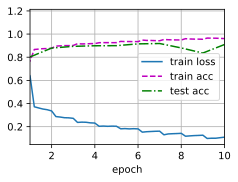

In [2]:
from torchinfo import summary
from d2l import torch as d2l


num_classes = 10
memory_efficient = True
load = False
progress = True

densenet121 = Constructor(num_classes, memory_efficient, load,
                          progress).densenet169()

net = densenet121

lr, num_epochs, batch_size = 0.05, 10, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu(1))